# The HELP masterlist summary figures
This notebook is to produce some figures for the paper describing the HELP masterlist paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))


laptop = True

This notebook was run with herschelhelp_internal version: 
1407877 (Mon Feb 4 12:56:29 2019 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib as mpl
mpl.use('pdf')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#plt.rc('figure', figsize=(10, 6))
from matplotlib_venn import venn3

import seaborn.apionly as sns
import time

from astropy import visualization as vz
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
from astropy.io.votable import parse
from astropy.io.votable import parse_single_table
from collections import OrderedDict
import os


import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux, flux_to_mag, aperture_correction

from pymoc import MOC
import healpy as hp
import pyvo as vo

import warnings
warnings.filterwarnings('ignore')

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
#Then we establish the VO connection to our database
service = vo.dal.TAPService("https://herschel-vos.phys.sussex.ac.uk/__system__/tap/run/tap"
                           )

In [4]:
dmu_loc = '../../../'
en1_moc = MOC(filename=dmu_loc +'dmu2/dmu2_field_coverages/ELAIS-N1_MOC.fits')
en1_servs_moc= MOC(filename=dmu_loc +'dmu0/dmu0_DataFusion-Spitzer/data/DF-SERVS_ELAIS-N1_MOC.fits')
en1_swire_moc= MOC(filename=dmu_loc +'dmu0/dmu0_DataFusion-Spitzer/data/DF-SWIRE_ELAIS-N1_MOC.fits')


print("SERVS: {}, SWIRE: {}".format(en1_servs_moc.area_sq_deg/en1_moc.area_sq_deg, 
                                    en1_swire_moc.area_sq_deg/en1_moc.area_sq_deg))


depths = Table.read(dmu_loc +'dmu1/dmu1_ml_ELAIS-N1/data/depths_elais-n1_20180216.fits')

# Pritine HSC catalogue
orig_hsc = Table.read(dmu_loc +'/dmu0/dmu0_HSC/data/HSC-PDR1_deep_ELAIS-N1.fits')[
    "object_id",
    "ra",
    "dec",
    "gmag_aperture10",
    "gmag_aperture15",
    "gmag_aperture20",
    "gmag_aperture30",
    "gmag_aperture40",
    "gmag_aperture57",
    "gmag_aperture84",
    "gmag_aperture118",
    "gmag_aperture168",
    "gmag_aperture235",
    "gmag_aperture10_err",
    "gmag_aperture15_err",
    "gmag_aperture20_err",
    "gmag_aperture30_err",
    "gmag_aperture40_err",
    "gmag_aperture57_err",
    "gmag_aperture84_err",
    "gmag_aperture118_err",
    "gmag_aperture168_err",
    "gmag_aperture235_err",
    "gclassification_extendedness"
]


gaia = Table.read(dmu_loc + "dmu0/dmu0_GAIA/data/GAIA_ELAIS-N1.fits")

wfc = Table.read(dmu_loc + '/dmu1/dmu1_ml_ELAIS-N1/data_tmp/INT-WFC.fits')
en1_area = MOC(filename=dmu_loc + 'dmu2/dmu2_field_coverages/ELAIS-N1_MOC.fits').area_sq_deg

# generate smaller catalogue with:
print("""stilts tpipe cmd='keepcols "m_suprime_r m_megacam_r m_wfc_g m_wfc_r" 
m_gpc1_r m_gpc1_g merr_gpc1_g m_ap_megacam_r m_megacam_g merr_megacam_g 
m_ukidss_j m_ukidss_k stellarity flag_optnir_obs flag_optnir_det
"' master_catalogue_elais-n1_20171016.fits omode=out out=cols_for_figs.fits""")

master_catalogue = Table.read(dmu_loc + "dmu1/dmu1_ml_ELAIS-N1/data/master_catalogue_elais-n1_20171016.fits")[ 
    "m_suprime_r", 
    "m_megacam_r",  
    'm_ap_megacam_r',
    "m_wfc_r",  
    "m_gpc1_r", 
    'm_wfc_g', 
    'm_gpc1_g',
    'merr_gpc1_g',
    'm_megacam_g',
    'merr_megacam_g',
    'm_ukidss_j',
    'm_ukidss_k',
    "f_ap_irac_i1",
    "stellarity",
    'flag_optnir_obs',
    'flag_optnir_det',
    
]


SERVS: 0.2041246653165556, SWIRE: 0.7317905659089361
stilts tpipe cmd='keepcols "m_suprime_r m_megacam_r m_wfc_g m_wfc_r" 
m_gpc1_r m_gpc1_g merr_gpc1_g m_ap_megacam_r m_megacam_g merr_megacam_g 
m_ukidss_j m_ukidss_k stellarity flag_optnir_obs flag_optnir_det
"' master_catalogue_elais-n1_20171016.fits omode=out out=cols_for_figs.fits


In [5]:
#colnames=Table.read("../dmu1/dmu1_ml_Herschel-Stripe-82/data/tiles/sub_catalogue_herschel-stripe-82_20180307_145.fits").colnames

In [6]:
#cols_to_keep = 'hp_idx '
#for col in colnames:
#    if col.startswith('f_') or col.startswith('ferr_'):
#        cols_to_keep += ' {}'.format(col)
        
#cols_to_keep

In [7]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

#filters_folder = "/opt/herschelhelp_python/database_builder/filters/"
if laptop:
    filters_folder = "/Users/rs548/GitHub/herschelhelp_python/database_builder/filters/"
else:
    filters_folder = "/opt/herschelhelp_python/database_builder/filters/"

In [8]:
filters = [
    ['wfc_u', 'WFC $u$', False ],
    ['megacam_u', 'Megacam $u$', True ], 

    ['wfc_g', 'WFC $g$', False ], 
    ['megacam_g', 'Megacam $g$', True ], 
    ['suprime_g', 'HSC $g$', False ], 
    ['gpc1_g', 'GPC1 $g$', False ], 

    ['wfc_r', 'WFC $r$', False ], 
    ['megacam_r', 'Megacam $r$', True ],
    ['suprime_r', 'HSC $r$', False ], 
    ['gpc1_r', 'GPC1 $r$', False ], 

    ['wfc_i', 'WFC $i$', False ], 
    ['suprime_i', 'HSC $i$', True ], 
    ['gpc1_i', '', False ], 

    ['wfc_z', 'WFC $z$', False ],  
    ['megacam_z', 'Megacam $z$', True ],  
    ['suprime_z', 'HSC $z$', False ],  
    ['gpc1_z', 'GPC1 $z$', False ],  

    ['suprime_y', 'HSC $y$', True ], 
    ['gpc1_y', 'GPC1 $y$', False ],  

    ['ukidss_j', 'UKIDSS $J$', True ], 
    ['ukidss_k', 'UKIDSS $K$', True ],  

    ['irac_i1', 'IRAC 1 (3.6 $\mu$m)', True ],  
    ['irac_i2', 'IRAC 2 (4.5 $\mu$m)', True ],  
    ['irac_i3', 'IRAC 3 (5.6 $\mu$m)', True ], 
    ['irac_i4', 'IRAC 4 (8.0 $\mu$m)', True ], 
    
]

In [9]:
data = []

for f in filters:
    data += [[f[0], Table(data = parse_single_table(filters_folder + f[0] +'.xml').array.data), f[1]]]

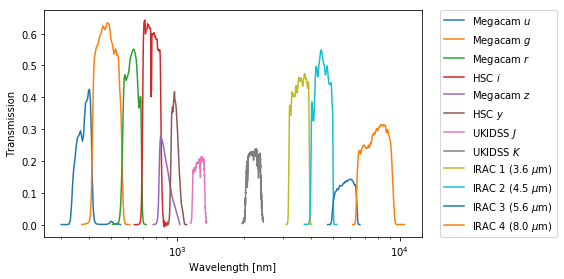

In [10]:
#plt.plot(wfc_u['Wavelength'],wfc_u['Transmission'], label='WFC u')
#plt.plot(megacam_u['Wavelength'],megacam_u['Transmission'], label='megacam u')

#plt.plot(wfc_g['Wavelength'],wfc_g['Transmission'], label='WFC g')

#plt.plot(irac_i4['Wavelength'],irac_i4['Transmission'], label='irac i4')


fig, ax = plt.subplots()
# Paper quality settings
plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

for f in filters:
    if f[2]:
        plt.plot(Table(data = parse_single_table(filters_folder + f[0] + '.xml').array.data)['Wavelength'] * 1e-1
            ,Table(data = parse_single_table(filters_folder + f[0] + '.xml').array.data)['Transmission']
            , label=f[1])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission')
plt.xscale('log')
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
#plt.title('Passbands on ELAIS-N1')



column_width_cm = 8.9
width_cm = 1.9 * column_width_cm
hieght_cm = width_cm / 1.618
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.savefig('./figs/filters.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('./figs/filters.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')


## Depths

In [12]:
theta, phi = hp.pixelfunc.pix2ang(hp.order2nside(13),depths['hp_idx_O_13'], nest = True) 
ra,dec = np.degrees(phi), -np.degrees(theta-np.pi/2)

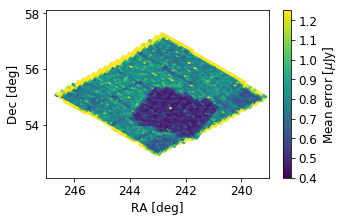

In [13]:
    # Scatter plot of the sources.
fig, ax = plt.subplots()
    
#offset_angle = np.angle(ra_diff.arcsec + dec_diff.arcsec * 1j)
#offset_dist = np.absolute(ra_diff.arcsec + dec_diff.arcsec * 1j)
#offset_distnorm = (offset_dist - np.min(offset_dist)) / np.max(offset_dist)

#cmap = mpl.colors.ListedColormap(sns.color_palette("Blues"))
#colors = cmap(depths['ferr_ap_irac_i1_mean'])  # The color is the angle
#colors[:, 3] = offset_distnorm  # The transparency is the distance

im = ax.scatter(ra, dec, c=depths['ferr_ap_irac_i1_mean'], 
                vmin=0.4, vmax=1.25, s=0.1)
#axis.set_xlabel("RA")
#axis.set_ylabel("Dec")

fig.colorbar(im, ax=ax).set_label('Mean error [$\mu$Jy]')
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
ax.axis('equal')

plt.xlim(247.,239.)

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.4 * column_width_cm
hieght_cm = width_cm / 1.618
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.savefig('./figs/depth_map.pdf', bbox_inches='tight')
plt.savefig('./figs/depth_map.png', bbox_inches='tight')


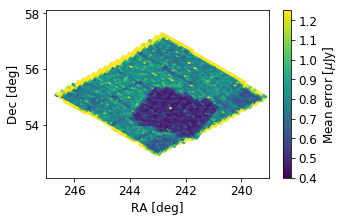

In [14]:
    # Scatter plot of the sources.
fig, ax = plt.subplots()
    
#offset_angle = np.angle(ra_diff.arcsec + dec_diff.arcsec * 1j)
#offset_dist = np.absolute(ra_diff.arcsec + dec_diff.arcsec * 1j)
#offset_distnorm = (offset_dist - np.min(offset_dist)) / np.max(offset_dist)

#cmap = mpl.colors.ListedColormap(sns.color_palette("Blues"))
#colors = cmap(depths['ferr_ap_irac_i1_mean'])  # The color is the angle
#colors[:, 3] = offset_distnorm  # The transparency is the distance

im = ax.scatter(ra, dec, c=depths['ferr_ap_irac_i1_mean'], 
                vmin=0.4, vmax=1.25, s=0.1, rasterized=True)
#axis.set_xlabel("RA")
#axis.set_ylabel("Dec")

fig.colorbar(im, ax=ax).set_label('Mean error [$\mu$Jy]')
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
ax.axis('equal')

plt.xlim(247.,239.)

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.4 * column_width_cm
hieght_cm = width_cm / 1.618
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.savefig('./figs/depth_map_raster.pdf', bbox_inches='tight')
plt.savefig('./figs/depth_map_raster.png', bbox_inches='tight')

In [17]:
depths.colnames


['hp_idx_O_13',
 'hp_idx_O_10',
 'ferr_ap_wfc_u_mean',
 'f_ap_wfc_u_p90',
 'ferr_wfc_u_mean',
 'f_wfc_u_p90',
 'ferr_ap_wfc_g_mean',
 'f_ap_wfc_g_p90',
 'ferr_wfc_g_mean',
 'f_wfc_g_p90',
 'ferr_ap_wfc_r_mean',
 'f_ap_wfc_r_p90',
 'ferr_wfc_r_mean',
 'f_wfc_r_p90',
 'ferr_ap_wfc_i_mean',
 'f_ap_wfc_i_p90',
 'ferr_wfc_i_mean',
 'f_wfc_i_p90',
 'ferr_ap_wfc_z_mean',
 'f_ap_wfc_z_p90',
 'ferr_wfc_z_mean',
 'f_wfc_z_p90',
 'ferr_ap_megacam_u_mean',
 'f_ap_megacam_u_p90',
 'ferr_megacam_u_mean',
 'f_megacam_u_p90',
 'ferr_ap_megacam_g_mean',
 'f_ap_megacam_g_p90',
 'ferr_megacam_g_mean',
 'f_megacam_g_p90',
 'ferr_ap_megacam_r_mean',
 'f_ap_megacam_r_p90',
 'ferr_megacam_r_mean',
 'f_megacam_r_p90',
 'ferr_ap_megacam_z_mean',
 'f_ap_megacam_z_p90',
 'ferr_megacam_z_mean',
 'f_megacam_z_p90',
 'ferr_ap_suprime_g_mean',
 'f_ap_suprime_g_p90',
 'ferr_suprime_g_mean',
 'f_suprime_g_p90',
 'ferr_ap_suprime_r_mean',
 'f_ap_suprime_r_p90',
 'ferr_suprime_r_mean',
 'f_suprime_r_p90',
 'ferr_ap_supr

In [18]:
average_depths = []
for f in filters:
    
    mean_err = np.nanmean(depths['ferr_ap_{}_mean'.format(f[0])])
    print("{}: mean flux error: {}, 3sigma log10( f [Jy]) : {}".format(f[0], mean_err, flux_to_mag(3.0*mean_err*1.e-6)[0]))
    average_depths += [(f[0], 1.0*mean_err*1.e-6, 
                        3.0*mean_err*1.e-6, 
                        5.0*mean_err*1.e-6)]
average_depths = np.array(average_depths,  dtype=[('band', "<U16"), ('1s', float), ('3s', float), ('5s', float)])

wfc_u: mean flux error: 4.338520526885986, 3sigma log10( f [Jy]) : 21.11384272176445
megacam_u: mean flux error: 0.015514050610363483, 3sigma log10( f [Jy]) : 27.230383853506076
wfc_g: mean flux error: 1.281677484512329, 3sigma log10( f [Jy]) : 22.437749975590997
megacam_g: mean flux error: 0.010639035142958164, 3sigma log10( f [Jy]) : 27.639941254555517
suprime_g: mean flux error: 0.017642125487327576, 3sigma log10( f [Jy]) : 27.09081959604557
gpc1_g: mean flux error: 0.49417333358880866, 3sigma log10( f [Jy]) : 23.47249859707805
wfc_r: mean flux error: 1.5445971488952637, 3sigma log10( f [Jy]) : 22.235158791056385
megacam_r: mean flux error: 0.020171120762825012, 3sigma log10( f [Jy]) : 26.9453717895098
suprime_r: mean flux error: 0.03673762083053589, 3sigma log10( f [Jy]) : 26.294419294492123
gpc1_r: mean flux error: 0.7111272150862947, 3sigma log10( f [Jy]) : 23.07732861430221
wfc_i: mean flux error: 3.2868664264678955, 3sigma log10( f [Jy]) : 21.415241724860657
suprime_i: mean flu

In [19]:
average_depths['1s'][average_depths['band'] == 'megacam_u']

array([1.55140506e-08])

In [20]:
def FWHM(X,Y):
    
    half_max = max(Y) / 2.
    #find when function crosses line half_max (when sign of diff flips)
    #take the 'derivative' of signum(half_max - Y[])
    d = half_max - Y
    #plot(X,d) #if you are interested
    #find the left and right most indexes
    low_end = X[np.where(d < 0)[0][0]]
    high_end = X[np.where(d < 0)[0][-1]]
    return low_end, high_end, (high_end - low_end)
#FWHM(np.array(ukidss_k['Wavelength']), np.array(ukidss_k['Transmission']))

In [21]:
wav_range = []
for dat in data:
    print(dat[0], FWHM(np.array(dat[1]['Wavelength']*1.e-1), np.array(dat[1]['Transmission'])))
    wav_range += [[dat[0], FWHM(np.array(dat[1]['Wavelength']*1.e-1), np.array(dat[1]['Transmission']))]]


wfc_u (335.5, 392.5, 57.0)
megacam_u (350.0, 410.0, 60.0)
wfc_g (426.0, 548.5, 122.5)
megacam_g (418.0, 558.0, 140.0)
suprime_g (409.0, 546.0, 137.0)
gpc1_g (426.0, 550.0, 124.0)
wfc_r (557.5, 691.0, 133.5)
megacam_r (568.0, 688.0, 120.0)
suprime_r (544.0, 696.0, 152.0)
gpc1_r (550.0, 690.0, 140.0)
wfc_i (697.0, 848.5, 151.5)
suprime_i (698.0, 842.0, 144.0)
gpc1_i (691.0, 819.0, 128.0)
wfc_z (850.0, 900.0, 50.0)
megacam_z (828.0, 916.0, 88.0)
suprime_z (854.0, 928.0, 74.0)
gpc1_z (819.0, 921.0, 102.0)
suprime_y (936.0, 1012.0, 76.0)
gpc1_y (920.0, 982.0, 62.0)
ukidss_j (1169.5, 1328.0, 158.5)
ukidss_k (2029.0, 2382.0, 353.0)
irac_i1 (3175.4001, 3916.4802, 741.0801)
irac_i2 (3998.0103, 5005.23, 1007.2197)
irac_i3 (5024.6304, 6409.67, 1385.0396)
irac_i4 (6441.52, 9259.68, 2818.1597)


In [22]:
average_depths['1s']

array([4.33852053e-06, 1.55140506e-08, 1.28167748e-06, 1.06390351e-08,
       1.76421255e-08, 4.94173334e-07, 1.54459715e-06, 2.01711208e-08,
       3.67376208e-08, 7.11127215e-07, 3.28686643e-06, 4.00569849e-08,
       7.60870822e-07, 9.72400761e-06, 4.63933498e-08, 1.08821712e-07,
       6.40443325e-07, 2.07470790e-07, 1.19048422e-06, 5.76056838e-07,
       7.02062845e-07, 8.13566751e-07, 1.03819569e-06, 5.45191941e-06,
       5.14597392e-06])

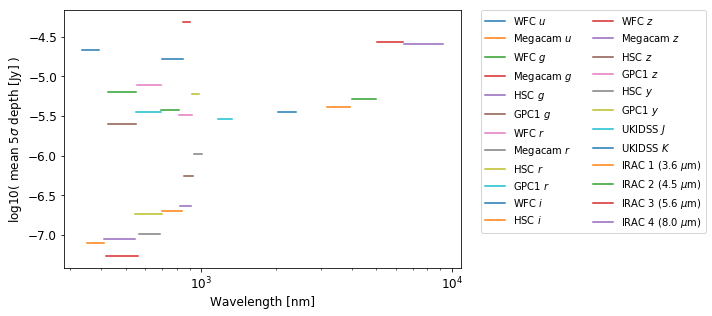

In [23]:
fig, ax = plt.subplots()
for dat in data:
    wav_deets = FWHM(np.array(dat[1]['Wavelength']*1.e-1), np.array(dat[1]['Transmission']))
    depth = np.log10(average_depths['5s'][average_depths['band'] == dat[0]])
    #print(depth)
    plt.plot([wav_deets[0],wav_deets[1]], [depth,depth], label=dat[2])
    
plt.xlabel('Wavelength [nm]')
plt.ylabel('log10( mean 5$\sigma$ depth [Jy] )')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2, fontsize=10)
#plt.ylim(-7, -3)
#plt.title('M5$\sigma$ depths on ELAIS-N1')

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

#ax.set_xticks([500, 1000, 1500, 10000]) 
#ax.set_xticklabels(["50k", "100k", ])

column_width_cm = 8.9
width_cm = 2.0 * column_width_cm
hieght_cm = width_cm / 1.5
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.savefig('./figs/depths.pdf', bbox_inches='tight')
plt.savefig('./figs/depths.png', bbox_inches='tight')

# HSC processing figures

In [24]:


RA_COL = "hsc_ra"
DEC_COL = "hsc_dec"

In [33]:

bands = ["g"]
apertures = ["10", "15", "20", "30", "40", "57", "84", "118", "168", "235"]

magnitudes = {}
magnitude_errors ={}
stellarities = {}

for band in bands:
    magnitudes[band] = np.array(
        [orig_hsc["{}mag_aperture{}".format(band, aperture)] for aperture in apertures]
    )
    magnitude_errors[band] = np.array(
        [orig_hsc["{}mag_aperture{}_err".format(band, aperture)] for aperture in apertures]
    )
    stellarities[band] = 1 - np.array(orig_hsc["{}classification_extendedness".format(band)])
    
    # Some sources have an infinite magnitude
    mask = np.isinf(magnitudes[band])
    magnitudes[band][mask] = np.nan
    magnitude_errors[band][mask] = np.nan
    
mag_corr = {}

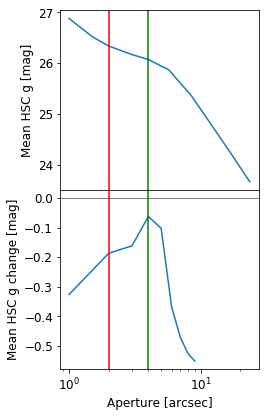

In [34]:

stel_threshold=0.9
labels=None

mags = magnitudes['g'][:, stellarities['g'] > stel_threshold].copy()
mag_diff = mags[1:, :] - mags[:-1, :]

fig, [ax1, ax2] = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={'hspace': 0},
    figsize=(9, 12)
)

ax1.plot([1, 1.5, 2.0, 3.0, 4.0, 5.7, 8.4, 11.8, 16.8, 23.5], np.nanmean(mags, axis=1))
ax1.axvline(x=2.0, c='r')
ax1.axvline(x=4.0, c='g')

ax2.plot(1+np.arange(len(mag_diff)),
         np.nanmean(mag_diff, axis=1))
ax2.axhline(0, c='black', linewidth=.5)
ax2.axvline(x=2.0, c='r')
ax2.axvline(x=4.0, c='g')

if labels is not None:
    ax2.xaxis.set_ticks(np.arange(magnitudes['g'].shape[0]))
    ax2.set_xticklabels(labels)
    ax2.set_xlabel("Aperture")
else:
    ax2.set_xlabel("Aperture [arcsec]")

ax1.set_ylabel("Mean HSC g [mag]")
ax2.set_ylabel("Mean HSC g change [mag]")

plt.xscale('log')
#plt.axvline(x=2.0, c='r')

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = 3 * width_cm / 1.618
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.savefig('./figs/aperture_correct.pdf', bbox_inches='tight')
plt.savefig('./figs/aperture_correct.png', bbox_inches='tight')

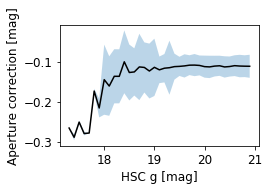

In [35]:
mag = orig_hsc['gmag_aperture20']
mag_target = orig_hsc['gmag_aperture40']
stellarity = stellarities['g']

mask = stellarity > .9

# We exclude the 0.1% brighter and fainter sources
mag_min, mag_max = np.nanpercentile(mag[mask], [.001, .999])
mag_min = np.floor(mag_min)
mag_max = np.ceil(mag_max)

mag_bins = np.arange(mag_min, mag_max, step=.1)

mag_cor = []
mag_std = []

for mag_bin_min in mag_bins:
    try:
        
        mag_diff, _, std = aperture_correction(
                mag, mag_target, stellarity, mag_bin_min, mag_bin_min + .1)
    except:
        #print('didntworked')
        mag_diff, std = np.nan, np.nan
    mag_cor.append(mag_diff)
    mag_std.append(std)

mag_cor = np.array(mag_cor)
mag_std = np.array(mag_std)

fig, ax = plt.subplots()

#plt.rc('figure', figsize=(9, 4))
plt.plot(mag_bins, mag_cor, color='black')
plt.fill_between(mag_bins, mag_cor - mag_std, mag_cor + mag_std, alpha=.3)#, facecolor='red')








plt.xlabel("HSC g [mag]")



plt.ylabel('Aperture correction [mag]')


#plt.title('M5$\sigma$ depths on ELAIS-N1')

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm / 1.6
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.savefig('./figs/ap_correct_mag.pdf', bbox_inches='tight')
plt.savefig('./figs/ap_correct_mag.png', bbox_inches='tight')

In [39]:
imported_columns = OrderedDict({
        "object_id": "hsc_id",
        "ra": "hsc_ra",
        "dec": "hsc_dec"
    })


catalogue = orig_hsc[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2017

# Clean table metadata
catalogue.meta = None

In [41]:

gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

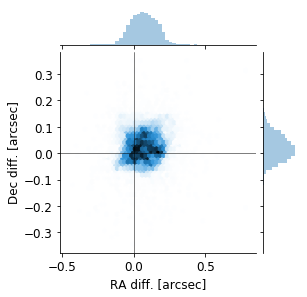

In [42]:
cat_ra = catalogue[RA_COL]
cat_ra.unit = u.deg
cat_dec = catalogue[DEC_COL]
cat_dec.unit = u.deg

gaia_coords.unit = u.deg
ref_ra = gaia_coords.ra

ref_dec = gaia_coords.dec

radius=0.6*u.arcsec
near_ra0=False
limit_nb_points=None 

cat_coords = SkyCoord(cat_ra, cat_dec)
ref_coords = SkyCoord(ref_ra, ref_dec)

idx, d2d, _ = cat_coords.match_to_catalog_sky(ref_coords)
to_keep = d2d <= radius

# We may want to limit the number of points used.
if limit_nb_points is not None and np.sum(to_keep) > limit_nb_points:
    random_mask = np.full(np.sum(to_keep), False, dtype=bool)
    random_mask[np.random.choice(
        np.arange(np.sum(to_keep)), limit_nb_points, replace=False)] = True
    to_keep[to_keep][~random_mask] = False

# Use ra between -180 and 180 when around ra=0
if near_ra0:
    cat_ra = cat_coords.ra.wrap_at(180 * u.deg)[to_keep]
    ref_ra = ref_coords[idx].ra.wrap_at(180 * u.deg)[to_keep]
else:
    cat_ra = cat_coords.ra[to_keep]
    ref_ra = ref_coords[idx].ra[to_keep]

cat_dec = cat_coords.dec[to_keep]
ref_dec = ref_coords[idx].dec[to_keep]

ra_diff = cat_ra - ref_ra
dec_diff = cat_dec - ref_dec

#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
#sns.set_style("dark")


# Joint plot

jointplot = sns.jointplot(ra_diff.arcsec, dec_diff.arcsec, kind='hex', size=4.0)
jointplot.set_axis_labels("RA diff. [arcsec]", "Dec diff. [arcsec]")
jointplot.ax_joint.axhline(0, color='black', linewidth=.5)
jointplot.ax_joint.axvline(0, color='black', linewidth=.5)



column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm 
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
plt.savefig('./figs/astrometry1.pdf', bbox_inches='tight')
plt.savefig('./figs/astrometry1.png', bbox_inches='tight')

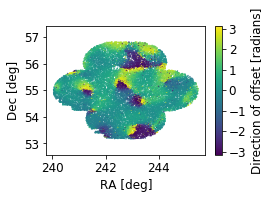

In [43]:
# Scatter plot of the sources.
fig, axis = plt.subplots()

offset_angle = np.angle(ra_diff.arcsec + dec_diff.arcsec * 1j)
offset_dist = np.absolute(ra_diff.arcsec + dec_diff.arcsec * 1j)
offset_distnorm = (offset_dist - np.min(offset_dist)) / np.max(offset_dist)

#cmap = mpl.colors.ListedColormap(sns.color_palette("husl", 300))
#colors = cmap(offset_angle)  # The color is the angle
#colors[:, 3] = offset_distnorm  # The transparency is the distance

im = axis.scatter(cat_ra, cat_dec, c=offset_angle,  s=0.2)#vmin=0.0, vmax=360.,
axis.set_xlabel("RA [deg]")
axis.set_ylabel("Dec [deg]")
axis.axis('equal')

fig.colorbar(im, ax=axis).set_label('Direction of offset [radians]')
# Optionally add a colorbar
#cax, _ = mpl.colorbar.make_axes(ax)
#cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm / 1.5
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
plt.savefig('./figs/astrometry2_old.pdf', bbox_inches='tight')
plt.savefig('./figs/astrometry2_old.png', bbox_inches='tight')

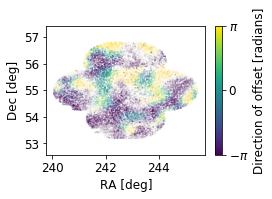

In [44]:
# Scatter plot of the sources.
fig, axis = plt.subplots()

offset_angle = np.angle(ra_diff.arcsec + dec_diff.arcsec * 1j)
offset_dist = np.absolute(ra_diff.arcsec + dec_diff.arcsec * 1j)
offset_distnorm = (offset_dist - np.min(offset_dist)) / np.max(offset_dist)

#cmap = mpl.colors.ListedColormap('rgb') #sns.color_palette("husl", 300))
#colors = cmap(offset_angle)  # The color is the angle
#colors[:, 3] = offset_distnorm  # The transparency is the distance

#colour = offset_angle
#colour[:, 3] = offset_distnorm 
cmap = mpl.cm.get_cmap('viridis')
colors = cmap(offset_angle)  # The color is the angle
colors[:, 3] = offset_distnorm  # The transparency is the distance
#normalize = matplotlib.colors.Normalize(vmin=min(offset_angle), vmax=max(offset_angle))
#colors = [cmap(normalize(value)) for value in offset_angle]

im = axis.scatter(cat_ra, cat_dec, c=colors,  s=0.2)#vmin=0.0, vmax=360.,
axis.set_xlabel("RA [deg]")
axis.set_ylabel("Dec [deg]")
axis.axis('equal')

#fig.colorbar(im, ax=axis).set_label('Direction of offset [radians]')
# Optionally add a colorbar
cax, _ = mpl.colorbar.make_axes(axis)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, ticks = [0, 0.5, 1])
cbar.set_label('Direction of offset [radians]')
cax.set_yticklabels(['$-\pi$', '0', '$\pi$'])
#cbar.set_clim(-np.pi, np.pi)


column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm / 1.5
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
plt.savefig('./figs/astrometry2.pdf', bbox_inches='tight')
plt.savefig('./figs/astrometry2.png', bbox_inches='tight')

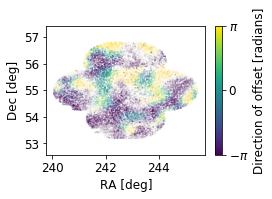

In [45]:
# Scatter plot of the sources.
fig, axis = plt.subplots()

offset_angle = np.angle(ra_diff.arcsec + dec_diff.arcsec * 1j)
offset_dist = np.absolute(ra_diff.arcsec + dec_diff.arcsec * 1j)
offset_distnorm = (offset_dist - np.min(offset_dist)) / np.max(offset_dist)

#cmap = mpl.colors.ListedColormap('rgb') #sns.color_palette("husl", 300))
#colors = cmap(offset_angle)  # The color is the angle
#colors[:, 3] = offset_distnorm  # The transparency is the distance

#colour = offset_angle
#colour[:, 3] = offset_distnorm 
cmap = mpl.cm.get_cmap('viridis')
colors = cmap(offset_angle)  # The color is the angle
colors[:, 3] = offset_distnorm  # The transparency is the distance
#normalize = matplotlib.colors.Normalize(vmin=min(offset_angle), vmax=max(offset_angle))
#colors = [cmap(normalize(value)) for value in offset_angle]

im = axis.scatter(cat_ra, cat_dec, c=colors,  s=0.2, rasterized=True)#vmin=0.0, vmax=360.,
axis.set_xlabel("RA [deg]")
axis.set_ylabel("Dec [deg]")
axis.axis('equal')

#fig.colorbar(im, ax=axis).set_label('Direction of offset [radians]')
# Optionally add a colorbar
cax, _ = mpl.colorbar.make_axes(axis)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, ticks = [0, 0.5, 1])
cbar.set_label('Direction of offset [radians]')
cax.set_yticklabels(['$-\pi$', '0', '$\pi$'])

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm / 1.5
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
plt.savefig('./figs/astrometry2_raster.pdf', bbox_inches='tight')
plt.savefig('./figs/astrometry2_raster.png', bbox_inches='tight')

In [48]:

hsc = orig_hsc['ra', 'dec']
hsc['ra'].name = 'hsc_ra'
hsc['dec'].name = 'hsc_dec'
master_catalogue1 = wfc
master_catalogue1['wfc_ra'].name = 'ra'
master_catalogue1['wfc_dec'].name = 'dec'

en1_area

13.507484555454763

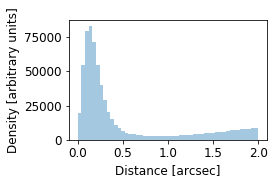

In [51]:
fig, ax = plt.subplots()

max_dist=2 * u.arcsec
_, _, d2d, _ = SkyCoord(
    master_catalogue1['ra'], master_catalogue1['dec']
).search_around_sky(
    SkyCoord(hsc['hsc_ra']*u.deg, hsc['hsc_dec']*u.deg), max_dist
)

ax = sns.distplot(d2d.arcsec, kde=False, ax=ax)

plt.xticks(np.arange(max_dist.value))
plt.xlabel("Distance [arcsec]")
ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0]) 


#plt.ylabel('Density [arcsec$^{-1}$]')
plt.ylabel('Density [arbitrary units]')
#ax.set_yticks([50000, 100000, 150000]) 
#ax.set_yticklabels(["50k", "100k", ])
#ax.set_yticklabels([ ])

#plt.title('M5$\sigma$ depths on ELAIS-N1')


plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm / 1.618
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)


plt.savefig('./figs/crossmatch.pdf', bbox_inches='tight')
plt.savefig('./figs/crossmatch.png', bbox_inches='tight')

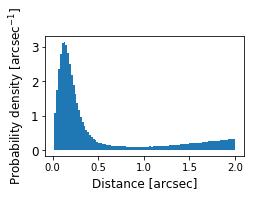

In [53]:



fig, ax = plt.subplots()

max_dist=2 * u.arcsec
_, _, d2d, _ = SkyCoord(
    master_catalogue1['ra'], master_catalogue1['dec']
).search_around_sky(
    SkyCoord(hsc['hsc_ra']*u.deg, hsc['hsc_dec']*u.deg), 
    max_dist
)
#ax = sns.distplot(d2d.arcsec, kde=False, ax=ax)

cells, fluxes = np.histogram(d2d.arcsec, bins=100, density=True)
ax.fill_between(fluxes[1:],
         cells , step='pre')

plt.xticks(np.arange(max_dist.value))
plt.xlabel("Distance [arcsec]")
ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0]) 


#plt.ylabel('Density [arcsec$^{-1}$]')
plt.ylabel('Probability density [arcsec$^{-1}$]')
#ax.set_yticks([50000, 100000, 150000]) 
#ax.set_yticklabels(["50k", "100k", ])
#ax.set_yticklabels([ ])

#plt.title('M5$\sigma$ depths on ELAIS-N1')


plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm / 1.618
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)


plt.savefig('./figs/crossmatch.pdf', bbox_inches='tight')
plt.savefig('./figs/crossmatch.png', bbox_inches='tight')

# Check plots

In [61]:

flag_obs = master_catalogue['flag_optnir_obs']
flag_det = master_catalogue['flag_optnir_det']

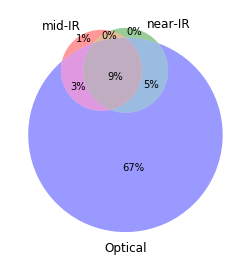

In [62]:
fig, ax = plt.subplots()
venn3(
    [
        np.sum(flag_det[flag_obs == 7] == 4),
        np.sum(flag_det[flag_obs == 7] == 2),
        np.sum(flag_det[flag_obs == 7] == 6),
        np.sum(flag_det[flag_obs == 7] == 1),
        np.sum(flag_det[flag_obs == 7] == 5),
        np.sum(flag_det[flag_obs == 7] == 3),
        np.sum(flag_det[flag_obs == 7] == 7)
    ],
    set_labels=('mid-IR', 'near-IR', 'Optical'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/np.sum(flag_det != 0)))
)
#plt.title("Detection of the {} sources detected\n in given wavelength domains "
#          "(among {} sources)".format(
#              locale.format('%d', np.sum(flag_det != 0), grouping=True),
#              locale.format('%d', len(flag_det), grouping=True)));
plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 2.0 * column_width_cm
hieght_cm = width_cm / 1.618
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.savefig('./figs/detection_pie.pdf', bbox_inches='tight')
plt.savefig('./figs/detection_pie.png', bbox_inches='tight')

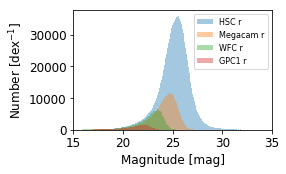

In [63]:
fig, ax = plt.subplots()

table=master_catalogue
column_names = ["m_suprime_r", "m_megacam_r", "m_wfc_r",  "m_gpc1_r"]
labels = ["HSC r", "Megacam r", "WFC r",  "GPC1 r"]

for name, label in zip(column_names, labels):
    mask = np.isfinite(table[name])
    if not np.isnan(table[name]).all():
        #vz.hist(table[name][mask], bins='scott', label=label, alpha=.5)
        ax =sns.distplot(table[name][mask], label=label,  kde=False, bins=1000)
    else:
        print("HELP warning: the column {} ({}) is empty.".format(
                name, label))

ax.legend(loc=1, fontsize=8)

plt.xlim(15.,35.)
plt.xlabel("Magnitude [mag]")
plt.xticks([15., 20., 25., 30., 35.],[15, 20, 25, 30, 35])

#plt.ylim(0.,0.4)
plt.ylabel('Number [dex$^{-1}$]')

plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm / 1.618
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.savefig('./figs/depths_mags.pdf', bbox_inches='tight')
plt.savefig('./figs/depths_mags.png', bbox_inches='tight')

Number of source used: 286866 / 4026292 (7.12%)


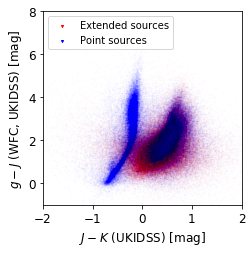

In [64]:
fig, ax = plt.subplots()

x = master_catalogue['m_ukidss_j'] - master_catalogue['m_ukidss_k']
y = master_catalogue['m_wfc_g'] - master_catalogue['m_ukidss_j']
x_label =  "$J - K$ (UKIDSS) [mag]"
y_label = "$g - J$ (WFC, UKIDSS) [mag]"
stellarity = master_catalogue["stellarity"]
alpha = 0.01 
leg_loc = 4 
invert_x=False 
invert_y=False 
x_limits=[-2.,2.] 
y_limits=[-1.,8.]

x = np.array(x)
y = np.array(y)
stellarity = np.array(stellarity)

    # Mask of the sources for which we have information to plot
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(stellarity)
print("Number of source used: {} / {} ({:.2f}%)".format(
    np.sum(mask), len(x), 100 * np.sum(mask)/len(x)))

if np.sum(mask) == 0:
    print('HELP warning: no sources with observations in both bands')

# We set the plot limits or zoom to remove outliers
if x_limits is not None:
    x_min, x_max = x_limits
else:
    x_min, x_max = np.percentile(x[mask], [.1, 99.9])
    x_delta = .1 * (x_max - x_min)
    x_min -= x_delta
    x_max += x_delta
if y_limits is not None:
    y_min, y_max = y_limits
else:
    y_min, y_max = np.percentile(y[mask], [.1, 99.9])
    y_delta = .1 * (y_max - y_min)
    y_min -= y_delta
    y_max += y_delta

point_source = stellarity[mask] > 0.7

#plt.figure(figsize=(10, 10), edgecolor="gray")
plt.xticks([-2,-1,0,1,2])

ax.scatter(x[mask][~point_source], y[mask][~point_source],
           color='r', marker='v', alpha=alpha, s=1,
           label="Extended sources")
ax.scatter(x[mask][point_source], y[mask][point_source],
            color='b', marker='v', alpha=alpha, s=1,
            label="Point sources")
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
legend = ax.legend( markerscale=2)
#legend.legendHandles[0]._sizes = [30]
#legend.legendHandles[1]._sizes = [30]

#for l in legend.legendHandles:
#    l.set_alpha(1)
#    l.set_marker('.')
#    l.set_size(10)
for lh in legend.legendHandles: 
    lh.set_alpha(1)

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
if invert_x:
    ax.set_xlim([x_max, x_min])
if invert_y:
    ax.set_ylim([y_max, y_min])

        
plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm / 1.0
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.savefig('./figs/colour.pdf', bbox_inches='tight')
plt.savefig('./figs/colour.png', bbox_inches='tight')


Number of source used: 286866 / 4026292 (7.12%)


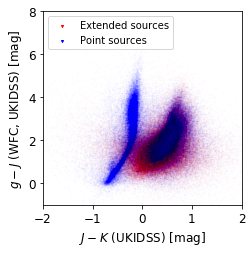

In [65]:
fig, ax = plt.subplots()

x = master_catalogue['m_ukidss_j'] - master_catalogue['m_ukidss_k']
y = master_catalogue['m_wfc_g'] - master_catalogue['m_ukidss_j']
x_label =  "$J - K$ (UKIDSS) [mag]"
y_label = "$g - J$ (WFC, UKIDSS) [mag]"
stellarity = master_catalogue["stellarity"]
alpha = 0.01 
leg_loc = 4 
invert_x=False 
invert_y=False 
x_limits=[-2.,2.] 
y_limits=[-1.,8.]

x = np.array(x)
y = np.array(y)
stellarity = np.array(stellarity)

    # Mask of the sources for which we have information to plot
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(stellarity)
print("Number of source used: {} / {} ({:.2f}%)".format(
    np.sum(mask), len(x), 100 * np.sum(mask)/len(x)))

if np.sum(mask) == 0:
    print('HELP warning: no sources with observations in both bands')

# We set the plot limits or zoom to remove outliers
if x_limits is not None:
    x_min, x_max = x_limits
else:
    x_min, x_max = np.percentile(x[mask], [.1, 99.9])
    x_delta = .1 * (x_max - x_min)
    x_min -= x_delta
    x_max += x_delta
if y_limits is not None:
    y_min, y_max = y_limits
else:
    y_min, y_max = np.percentile(y[mask], [.1, 99.9])
    y_delta = .1 * (y_max - y_min)
    y_min -= y_delta
    y_max += y_delta

point_source = stellarity[mask] > 0.7

#plt.figure(figsize=(10, 10), edgecolor="gray")
plt.xticks([-2,-1,0,1,2])

ax.scatter(x[mask][~point_source], y[mask][~point_source],
           color='r', marker='v', alpha=alpha, s=1,
           label="Extended sources", rasterized=True)
ax.scatter(x[mask][point_source], y[mask][point_source],
            color='b', marker='v', alpha=alpha, s=1,
            label="Point sources", rasterized=True)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
legend = ax.legend( markerscale=2)
#legend.legendHandles[0]._sizes = [30]
#legend.legendHandles[1]._sizes = [30]

#for l in legend.legendHandles:
#    l.set_alpha(1)
#    l.set_marker('.')
#    l.set_size(10)
for lh in legend.legendHandles: 
    lh.set_alpha(1)

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
if invert_x:
    ax.set_xlim([x_max, x_min])
if invert_y:
    ax.set_ylim([y_max, y_min])

        
plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm / 1.0
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.savefig('./figs/colour_raster.pdf', bbox_inches='tight')
plt.savefig('./figs/colour_raster.png', bbox_inches='tight')

In [16]:
colour_query="""
SELECT
m_suprime_g,
m_ukidss_j,
m_ukidss_k,
stellarity
FROM herschelhelp.main
WHERE
m_suprime_g IS NOT NULL
AND m_ukidss_j IS NOT NULL
AND m_ukidss_k IS NOT NULL
"""
job = service.submit_job(colour_query)
job.run()
job_url = job.url
job_result = vo.dal.tap.AsyncTAPJob(job_url)
start_time = time.time()
wait = 10.
while job.phase == 'EXECUTING':
            #print('Job still running after {} seconds.'.format(round(time.time() - start_time)))
    time.sleep(wait) 
            #wait *=2

print(job.phase)
result = job_result.fetch_result()
colour_tab = result.table

COMPLETED


Number of source used: 1077488 / 1077773 (99.97%)


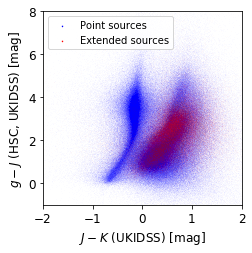

In [24]:
fig, ax = plt.subplots()

x = colour_tab['m_ukidss_j'] - colour_tab['m_ukidss_k']
y = colour_tab['m_suprime_g'] - colour_tab['m_ukidss_j']
x_label =  "$J - K$ (UKIDSS) [mag]"
y_label = "$g - J$ (HSC, UKIDSS) [mag]"
stellarity = colour_tab["stellarity"]
alpha = 0.01 
leg_loc = 4 
invert_x=False 
invert_y=False 
x_limits=[-2.,2.] 
y_limits=[-1.,8.]

x = np.array(x)
y = np.array(y)
stellarity = np.array(stellarity)

    # Mask of the sources for which we have information to plot
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(stellarity)
print("Number of source used: {} / {} ({:.2f}%)".format(
    np.sum(mask), len(x), 100 * np.sum(mask)/len(x)))

if np.sum(mask) == 0:
    print('HELP warning: no sources with observations in both bands')

# We set the plot limits or zoom to remove outliers
if x_limits is not None:
    x_min, x_max = x_limits
else:
    x_min, x_max = np.percentile(x[mask], [.1, 99.9])
    x_delta = .1 * (x_max - x_min)
    x_min -= x_delta
    x_max += x_delta
if y_limits is not None:
    y_min, y_max = y_limits
else:
    y_min, y_max = np.percentile(y[mask], [.1, 99.9])
    y_delta = .1 * (y_max - y_min)
    y_min -= y_delta
    y_max += y_delta

point_source = stellarity[mask] > 0.8
extended_source = stellarity[mask] < 0.2

#plt.figure(figsize=(10, 10), edgecolor="gray")
plt.xticks([-2,-1,0,1,2])


ax.scatter(x[mask][point_source], y[mask][point_source],
            color='b', marker='v', alpha=alpha, s=0.1,
            label="Point sources", rasterized=True)
ax.scatter(x[mask][extended_source], y[mask][extended_source],
           color='r', marker='v', alpha=alpha, s=0.1,
           label="Extended sources", rasterized=True)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
legend = ax.legend( markerscale=2)
#legend.legendHandles[0]._sizes = [30]
#legend.legendHandles[1]._sizes = [30]

#for l in legend.legendHandles:
#    l.set_alpha(1)
#    l.set_marker('.')
#    l.set_size(10)
for lh in legend.legendHandles: 
    lh.set_alpha(1)

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
if invert_x:
    ax.set_xlim([x_max, x_min])
if invert_y:
    ax.set_ylim([y_max, y_min])

        
plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm / 1.0
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.savefig('./figs/colour_raster_tot.pdf', bbox_inches='tight')
plt.savefig('./figs/colour_raster_tot.png', bbox_inches='tight')

Number of source used: 1487529 / 4026292 (36.95%)


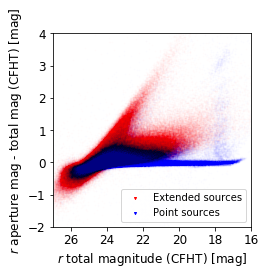

In [66]:


fig, ax = plt.subplots()

x = master_catalogue['m_megacam_r']
y = master_catalogue['m_ap_megacam_r'] - master_catalogue['m_megacam_r']
x_label =  "$r$ total magnitude (CFHT) [mag]"
y_label = "$r$ aperture mag - total mag (CFHT) [mag]"
stellarity = master_catalogue["stellarity"]
alpha = 0.009 
leg_loc = 4 
invert_x=False 
invert_y=False 
x_limits=[27.,16.] 
y_limits=[-2.,4.]

x = np.array(x)
y = np.array(y)
stellarity = np.array(stellarity)

    # Mask of the sources for which we have information to plot
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(stellarity)
print("Number of source used: {} / {} ({:.2f}%)".format(
    np.sum(mask), len(x), 100 * np.sum(mask)/len(x)))

if np.sum(mask) == 0:
    print('HELP warning: no sources with observations in both bands')

# We set the plot limits or zoom to remove outliers
if x_limits is not None:
    x_min, x_max = x_limits
else:
    x_min, x_max = np.percentile(x[mask], [.1, 99.9])
    x_delta = .1 * (x_max - x_min)
    x_min -= x_delta
    x_max += x_delta
if y_limits is not None:
    y_min, y_max = y_limits
else:
    y_min, y_max = np.percentile(y[mask], [.1, 99.9])
    y_delta = .1 * (y_max - y_min)
    y_min -= y_delta
    y_max += y_delta

point_source = stellarity[mask] > 0.7

#plt.figure(figsize=(10, 10), edgecolor="gray")
plt.xticks([26,24,22,20,18,16])

ax.scatter(x[mask][~point_source], y[mask][~point_source],
           color='r', marker='v', alpha=alpha, s=1,
           label="Extended sources")
ax.scatter(x[mask][point_source], y[mask][point_source],
            color='b', marker='v', alpha=alpha, s=1,
            label="Point sources")
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
legend = ax.legend( markerscale=2)
#legend.legendHandles[0]._sizes = [30]
#legend.legendHandles[1]._sizes = [30]

#for l in legend.legendHandles:
#    l.set_alpha(1)
#    l.set_marker('.')
#    l.set_size(10)
for lh in legend.legendHandles: 
    lh.set_alpha(1)

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
if invert_x:
    ax.set_xlim([x_max, x_min])
if invert_y:
    ax.set_ylim([y_max, y_min])

        
plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm 
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.savefig('./figs/ap_vs_tot.pdf', bbox_inches='tight')
plt.savefig('./figs/ap_vs_tot.png', bbox_inches='tight')

Number of source used: 1487529 / 4026292 (36.95%)


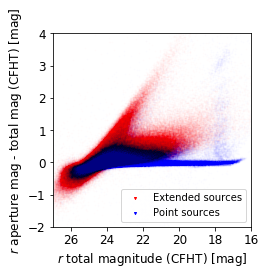

In [67]:
fig, ax = plt.subplots()

x = master_catalogue['m_megacam_r']
y = master_catalogue['m_ap_megacam_r'] - master_catalogue['m_megacam_r']
x_label =  "$r$ total magnitude (CFHT) [mag]"
y_label = "$r$ aperture mag - total mag (CFHT) [mag]"
stellarity = master_catalogue["stellarity"]
alpha = 0.009 
leg_loc = 4 
invert_x=False 
invert_y=False 
x_limits=[27.,16.] 
y_limits=[-2.,4.]

x = np.array(x)
y = np.array(y)
stellarity = np.array(stellarity)

    # Mask of the sources for which we have information to plot
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(stellarity)
print("Number of source used: {} / {} ({:.2f}%)".format(
    np.sum(mask), len(x), 100 * np.sum(mask)/len(x)))

if np.sum(mask) == 0:
    print('HELP warning: no sources with observations in both bands')

# We set the plot limits or zoom to remove outliers
if x_limits is not None:
    x_min, x_max = x_limits
else:
    x_min, x_max = np.percentile(x[mask], [.1, 99.9])
    x_delta = .1 * (x_max - x_min)
    x_min -= x_delta
    x_max += x_delta
if y_limits is not None:
    y_min, y_max = y_limits
else:
    y_min, y_max = np.percentile(y[mask], [.1, 99.9])
    y_delta = .1 * (y_max - y_min)
    y_min -= y_delta
    y_max += y_delta

point_source = stellarity[mask] > 0.7

#plt.figure(figsize=(10, 10), edgecolor="gray")
plt.xticks([26,24,22,20,18,16])

ax.scatter(x[mask][~point_source], y[mask][~point_source],
           color='r', marker='v', alpha=alpha, s=1,
           label="Extended sources", rasterized=True)
ax.scatter(x[mask][point_source], y[mask][point_source],
            color='b', marker='v', alpha=alpha, s=1,
            label="Point sources", rasterized=True)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
legend = ax.legend( markerscale=2)
#legend.legendHandles[0]._sizes = [30]
#legend.legendHandles[1]._sizes = [30]

#for l in legend.legendHandles:
#    l.set_alpha(1)
#    l.set_marker('.')
#    l.set_size(10)
for lh in legend.legendHandles: 
    lh.set_alpha(1)

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
if invert_x:
    ax.set_xlim([x_max, x_min])
if invert_y:
    ax.set_ylim([y_max, y_min])

        
plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

column_width_cm = 8.9
width_cm = 1.0 * column_width_cm
hieght_cm = width_cm 
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
plt.savefig('./figs/ap_vs_tot_raster.pdf', bbox_inches='tight')
plt.savefig('./figs/ap_vs_tot_raster.png', bbox_inches='tight')

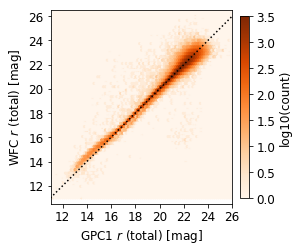

In [68]:
x = master_catalogue['m_gpc1_r']
y = master_catalogue['m_wfc_r']
labels=("GPC1 $r$ (total) [mag]", "WFC $r$ (total) [mag]")

x_label, y_label = labels

# Use only finite values
mask = np.isfinite(x) & np.isfinite(y)
x = np.copy(x[mask])
y = np.copy(y[mask])
alpha = 0.01


fig, ax = plt.subplots()



# Hexbin
im = ax.hexbin(x, y, cmap='Oranges', bins="log")

fig.colorbar(im, ax=ax, label="log10(count)",fraction=0.046, pad=0.04)
#ax.scatter(x, y,
#            color='b', marker='v', alpha=alpha, s=1,
#            label="Point sources")
min_val = np.min(np.r_[x, y])
max_val = np.max(np.r_[x, y])

#im = ax.plot([min_val, max_val], [min_val, max_val], "k:")

#fig.colorbar(im, ax=ax).set_label('Mean error ($\mu$Jy)')

ax.plot([min_val, max_val], [min_val, max_val], "k:")
#


#ax.autoscale(False)
ax.set_xlabel(labels[0])
ax.set_ylabel(labels[1])
ax.axis('equal')
#display(fig)
#plt.close()


plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

plt.xticks([12,14,16,18,20,22,24,26])
plt.yticks([12,14,16,18,20,22,24,26])

column_width_cm = 8.9
width_cm =  column_width_cm
hieght_cm = width_cm 
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
ax.set_xlim([11, 26])
ax.set_ylim([11, 26])
plt.savefig('./figs/mag_compare.pdf', bbox_inches='tight')
plt.savefig('./figs/mag_compare.png', bbox_inches='tight')

And in terms of mag difference at reviewers request

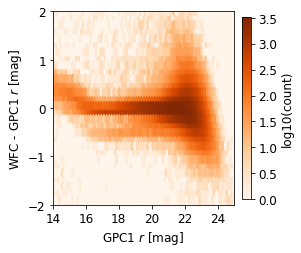

In [80]:
x = master_catalogue['m_gpc1_r']
y = master_catalogue['m_wfc_r']
labels=( "GPC1 $r$ [mag]", "WFC - GPC1 $r$ [mag]")

x_label, y_label = labels

# Use only finite values
mask = np.isfinite(x) & np.isfinite(y)
x = np.copy(x[mask])
y = np.copy(y[mask] - x)
alpha = 0.01


fig, ax = plt.subplots()



# Hexbin
im = ax.hexbin(x, y, cmap='Oranges', bins="log")

fig.colorbar(im, ax=ax, label="log10(count)",fraction=0.046, pad=0.04)
#ax.scatter(x, y,
#            color='b', marker='v', alpha=alpha, s=1,
#            label="Point sources")
min_val = np.min(np.r_[x, y])
max_val = np.max(np.r_[x, y])

#im = ax.plot([min_val, max_val], [min_val, max_val], "k:")

#fig.colorbar(im, ax=ax).set_label('Mean error ($\mu$Jy)')

#ax.plot([min_val, max_val], [min_val, max_val], "k:")
#


#ax.autoscale(False)
ax.set_xlabel(labels[0])
ax.set_ylabel(labels[1])
#ax.axis('equal')
#display(fig)
#plt.close()


plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)


plt.xticks([12,14,16,18,20,22,24])
plt.yticks([-2, -1, 0, 1, 2])
ax.set_xlim([14, 25])
ax.set_ylim([-2, 2])

column_width_cm = 8.9
width_cm =  column_width_cm
hieght_cm = width_cm 
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)

plt.savefig('./figs/mag_compare_diff.pdf', bbox_inches='tight')
plt.savefig('./figs/mag_compare_diff.png', bbox_inches='tight')

# Outliers

GPC1 $g$ - Megacam $g$ (Total) [mag] (149397 sources):
- Median: 0.08
- Median Absolute Deviation: 0.15
- 1% percentile: -3.053208236694336
- 99% percentile: 0.909821548461915
Outliers separation: log(chi2) = 5.44
Number of outliers: 5600



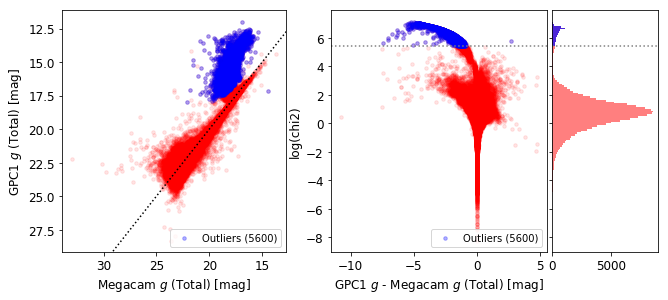

In [69]:



x = master_catalogue['m_megacam_g']
y = master_catalogue['m_gpc1_g']
xerr = master_catalogue['merr_megacam_g']
yerr = master_catalogue['merr_gpc1_g']
labels=labels=("Megacam $g$ (Total) [mag]", "GPC1 $g$ (Total) [mag]")
savefig=True
    

    

    
fig = plt.figure(figsize=(13, 6))

gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=0.4, wspace=0.05)
ax1 = plt.subplot(gs1[:, :])

gs2 = gridspec.GridSpec(1, 3)
gs2.update(left=0.47, right=0.98, hspace=0.05, wspace=0.05)
ax2 = plt.subplot(gs2[:, :-1])
ax3 = plt.subplot(gs2[:, -1], sharey=ax2)

    
# Use only finite values
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(xerr) & np.isfinite(yerr)
x = np.copy(x[mask])
y = np.copy(y[mask])
xerr = np.copy(xerr[mask])
yerr = np.copy(yerr[mask])
    
# mag1 - mag2
diff = y - x

x_label, y_label = labels
    
# If the difference is all NaN there is nothing to compare.
if np.isnan(diff).all():
    print("No sources have both {} and {} values.".format(
        x_label, y_label))
    print("")

# Set the minimum error to 10^-3
np.clip(xerr, 1e-3, np.max(xerr), out=xerr)
np.clip(yerr, 1e-3, np.max(yerr), out=yerr)

# Median, Median absolute deviation and 1% and 99% percentiles
diff_median = np.median(diff)
diff_mad = np.median(np.abs(diff - diff_median))
diff_1p, diff_99p = np.percentile(diff, [1., 99.])
diff_25p, diff_75p = np.percentile(diff, [25., 75.])
    
    
diff_label =  "GPC1 $g$ - Megacam $g$ (Total) [mag]" # "{} - {}".format(y_label, x_label)

print("{} ({} sources):".format(diff_label, len(x)))
print("- Median: {:.2f}".format(diff_median))
print("- Median Absolute Deviation: {:.2f}".format(diff_mad))
print("- 1% percentile: {}".format(diff_1p))
print("- 99% percentile: {}".format(diff_99p))

    
# Chi2 (Normalized difference)   
ichi2 = np.power(diff, 2) / (np.power(xerr, 2) + np.power(yerr, 2))
    
# Use only non-null values of ichi2
mask2 = ichi2 != 0.0
diff, ichi2 = np.copy(diff[mask2]), np.copy(ichi2[mask2])
x, y, xerr, yerr = np.copy(x[mask2]), np.copy(y[mask2]), np.copy(xerr[mask2]), np.copy(yerr[mask2])

# Outliers (5sigma)
log_ichi2_25p, log_ichi2_75p = np.percentile(np.log10(ichi2), [25., 75.])
out_lim = log_ichi2_75p + 3.2*abs(log_ichi2_25p-log_ichi2_75p)
    
outliers = np.log10(ichi2) > out_lim 
nb_outliers = len(x[outliers])
    
print("Outliers separation: log(chi2) = {:.2f}".format(out_lim))
print("Number of outliers: {}".format(nb_outliers))

print("")

# Comparing mag
ax1.scatter(x, y, marker='.', alpha=0.1, s=50, color='r')
ax1.scatter(x[outliers], y[outliers], marker='.', c='b', alpha=0.3, s=50, label='Outliers ({})'.format(nb_outliers))
min_val = np.min(np.r_[x, y])
max_val = np.max(np.r_[x, y])
ax1.autoscale(False)
ax1.plot([min_val, max_val], [min_val, max_val], "k:")
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax1.legend(loc='lower right', numpoints=1)
    

# Chi2 vs Diff
#ax1.set_yscale('log')    # to place before scatter to avoid issues
ax2.scatter(diff, np.log10(ichi2), marker='.', alpha=0.1, s=50, color='r')
if nb_outliers != 0:
    ax2.scatter(diff[outliers], np.log10(ichi2[outliers]), marker='.', alpha=0.3, s=50, color='b',\
                    label='Outliers ({})'.format(nb_outliers))
ax2.axhline(out_lim, color='grey', linestyle=':')
ax2.set_xlabel(diff_label)
ax2.set_ylabel('log(chi2)')
ax2.legend(loc='lower right', numpoints=1)
    
# Hist
n, bins, patches = vz.hist(np.log10(ichi2), ax=ax3, bins='knuth', facecolor='red', lw = 2, alpha=0.5,\
                                   orientation="horizontal")
if nb_outliers > 3:
        n, bins, patches = vz.hist(np.log10(ichi2[outliers]), ax=ax3, bins=bins, facecolor='b', lw = 2, alpha=0.7,\
                                   orientation="horizontal")
ax3.axhline(out_lim, color='grey', linestyle=':')
ax3.yaxis.set_tick_params(labelleft=False)
    
# Save ex. fig


plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)



column_width_cm = 8.9
width_cm =  2.5* column_width_cm
hieght_cm = width_cm /2
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
ax.set_xlim([11, 26])
ax.set_ylim([11, 26])
plt.savefig('./figs/mag_compare.pdf', bbox_inches='tight')
plt.savefig('./figs/mag_compare.png', bbox_inches='tight')


survey_label = ((diff_label.replace(" ", "_")).replace("(", "")).replace(")", "")
   
plt.savefig("./figs/outliers.png" , bbox_inches='tight')
plt.savefig("./figs/outliers.pdf" , bbox_inches='tight')
    

In [70]:
gs1

GPC1 $g$ - Megacam $g$ (Total) [mag] (149397 sources):
- Median: 0.08
- Median Absolute Deviation: 0.15
- 1% percentile: -3.053208236694336
- 99% percentile: 0.909821548461915
Outliers separation: log(chi2) = 5.44
Number of outliers: 5600



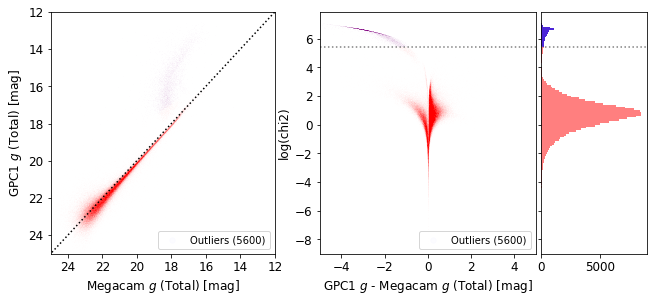

In [42]:
x = master_catalogue['m_megacam_g']
y = master_catalogue['m_gpc1_g']
xerr = master_catalogue['merr_megacam_g']
yerr = master_catalogue['merr_gpc1_g']
labels=labels=("Megacam $g$ (Total) [mag]", "GPC1 $g$ (Total) [mag]")
savefig=True
    

point_size = 0.05
alpha = 0.01
    
fig = plt.figure(figsize=(13, 6))

gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=0.4, wspace=0.05)
ax1 = plt.subplot(gs1[:, :])

gs2 = gridspec.GridSpec(1, 3)
gs2.update(left=0.47, right=0.98, hspace=0.05, wspace=0.05)
ax2 = plt.subplot(gs2[:, :-1])
ax3 = plt.subplot(gs2[:, -1], sharey=ax2)

    
# Use only finite values
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(xerr) & np.isfinite(yerr)
x = np.copy(x[mask])
y = np.copy(y[mask])
xerr = np.copy(xerr[mask])
yerr = np.copy(yerr[mask])
    
# mag1 - mag2
diff = y - x

x_label, y_label = labels
    
# If the difference is all NaN there is nothing to compare.
if np.isnan(diff).all():
    print("No sources have both {} and {} values.".format(
        x_label, y_label))
    print("")

# Set the minimum error to 10^-3
np.clip(xerr, 1e-3, np.max(xerr), out=xerr)
np.clip(yerr, 1e-3, np.max(yerr), out=yerr)

# Median, Median absolute deviation and 1% and 99% percentiles
diff_median = np.median(diff)
diff_mad = np.median(np.abs(diff - diff_median))
diff_1p, diff_99p = np.percentile(diff, [1., 99.])
diff_25p, diff_75p = np.percentile(diff, [25., 75.])
    
    
diff_label =  "GPC1 $g$ - Megacam $g$ (Total) [mag]" # "{} - {}".format(y_label, x_label)

print("{} ({} sources):".format(diff_label, len(x)))
print("- Median: {:.2f}".format(diff_median))
print("- Median Absolute Deviation: {:.2f}".format(diff_mad))
print("- 1% percentile: {}".format(diff_1p))
print("- 99% percentile: {}".format(diff_99p))

    
# Chi2 (Normalized difference)   
ichi2 = np.power(diff, 2) / (np.power(xerr, 2) + np.power(yerr, 2))
    
# Use only non-null values of ichi2
mask2 = ichi2 != 0.0
diff, ichi2 = np.copy(diff[mask2]), np.copy(ichi2[mask2])
x, y, xerr, yerr = np.copy(x[mask2]), np.copy(y[mask2]), np.copy(xerr[mask2]), np.copy(yerr[mask2])

# Outliers (5sigma)
log_ichi2_25p, log_ichi2_75p = np.percentile(np.log10(ichi2), [25., 75.])
out_lim = log_ichi2_75p + 3.2*abs(log_ichi2_25p-log_ichi2_75p)
    
outliers = np.log10(ichi2) > out_lim 
nb_outliers = len(x[outliers])
    
print("Outliers separation: log(chi2) = {:.2f}".format(out_lim))
print("Number of outliers: {}".format(nb_outliers))

print("")

# Comparing mag
ax1.scatter(x, y, marker='.', alpha=alpha, s=point_size, color='r', rasterized=True)
ax1.scatter(x[outliers], y[outliers], marker='.', c='b', 
            alpha=alpha, s=point_size, label='Outliers ({})'.format(nb_outliers), rasterized=True)
min_val = np.min(np.r_[x, y])
max_val = np.max(np.r_[x, y])
ax1.autoscale(False)
ax1.plot([min_val, max_val], [min_val, max_val], "k:")
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax1.legend(loc='lower right', numpoints=1, markerscale=50.)
    

# Chi2 vs Diff
#ax1.set_yscale('log')    # to place before scatter to avoid issues
ax2.scatter(diff, np.log10(ichi2), marker='.', alpha=alpha, s=point_size, color='r', rasterized=True)
if nb_outliers != 0:
    ax2.scatter(diff[outliers], np.log10(ichi2[outliers]), marker='.', alpha=alpha, s=point_size, color='b',\
                    label='Outliers ({})'.format(nb_outliers), rasterized=True)
ax2.axhline(out_lim, color='grey', linestyle=':')
ax2.set_xlabel(diff_label)
ax2.set_ylabel('log(chi2)')
ax2.legend(loc='lower right', numpoints=1, markerscale=50.)
    
# Hist
n, bins, patches = vz.hist(np.log10(ichi2), ax=ax3, bins='knuth', facecolor='red', lw = 2, alpha=0.5,\
                                   orientation="horizontal")
if nb_outliers > 3:
        n, bins, patches = vz.hist(np.log10(ichi2[outliers]), ax=ax3, bins=bins, facecolor='b', lw = 2, alpha=0.7,\
                                   orientation="horizontal")
ax3.axhline(out_lim, color='grey', linestyle=':')
ax3.yaxis.set_tick_params(labelleft=False)
    
# Save ex. fig


plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)



column_width_cm = 8.9
width_cm =  2.5* column_width_cm
hieght_cm = width_cm /2
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
ax1.set_xlim([25, 12])
ax1.set_ylim([25, 12])
ax1.set_xticks([24, 22,20,18,16,14,12])
ax2.set_xlim([-5, 5])
plt.savefig('./figs/mag_compare.pdf', bbox_inches='tight')
plt.savefig('./figs/mag_compare.png', bbox_inches='tight')


survey_label = ((diff_label.replace(" ", "_")).replace("(", "")).replace(")", "")
   
plt.savefig("./figs/outliers_raster.png" , bbox_inches='tight')
plt.savefig("./figs/outliers_raster.pdf" , bbox_inches='tight')

GPC1 $g$ - Megacam $g$ (Total) [mag] (149397 sources):
- Median: 0.08
- Median Absolute Deviation: 0.15
- 1% percentile: -3.053208236694336
- 99% percentile: 0.909821548461915
Outliers separation: log(chi2) = 5.35
Number of outliers: 752



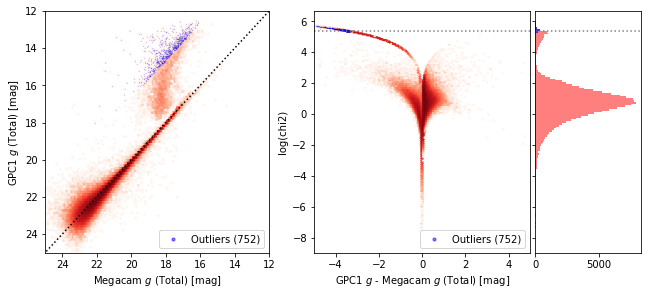

In [5]:
x = master_catalogue['m_megacam_g']
y = master_catalogue['m_gpc1_g']
xerr = master_catalogue['merr_megacam_g']
yerr = master_catalogue['merr_gpc1_g']
labels=labels=("Megacam $g$ (Total) [mag]", "GPC1 $g$ (Total) [mag]")
savefig=True
    

point_size = 0.1
alpha = 0.5
    
fig = plt.figure(figsize=(13, 6))

gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=0.4, wspace=0.05)
ax1 = plt.subplot(gs1[:, :])

gs2 = gridspec.GridSpec(1, 3)
gs2.update(left=0.47, right=0.98, hspace=0.05, wspace=0.05)
ax2 = plt.subplot(gs2[:, :-1])
ax3 = plt.subplot(gs2[:, -1], sharey=ax2)

    
# Use only finite values
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(xerr) & np.isfinite(yerr)
x = np.copy(x[mask])
y = np.copy(y[mask])
xerr = np.copy(xerr[mask])
yerr = np.copy(yerr[mask])
    
# mag1 - mag2
diff = y - x

x_label, y_label = labels
    
# If the difference is all NaN there is nothing to compare.
if np.isnan(diff).all():
    print("No sources have both {} and {} values.".format(
        x_label, y_label))
    print("")

# Set the minimum error to 10^-3
np.clip(xerr, 5e-3, np.max(xerr), out=xerr)
np.clip(yerr, 5e-3, np.max(yerr), out=yerr)

# Median, Median absolute deviation and 1% and 99% percentiles
diff_median = np.median(diff)
diff_mad = np.median(np.abs(diff - diff_median))
diff_1p, diff_99p = np.percentile(diff, [1., 99.])
diff_25p, diff_75p = np.percentile(diff, [25., 75.])
    
    
diff_label =  "GPC1 $g$ - Megacam $g$ (Total) [mag]" # "{} - {}".format(y_label, x_label)

print("{} ({} sources):".format(diff_label, len(x)))
print("- Median: {:.2f}".format(diff_median))
print("- Median Absolute Deviation: {:.2f}".format(diff_mad))
print("- 1% percentile: {}".format(diff_1p))
print("- 99% percentile: {}".format(diff_99p))

    
# Chi2 (Normalized difference)   
ichi2 = np.power(diff, 2) / (np.power(xerr, 2) + np.power(yerr, 2))
    
# Use only non-null values of ichi2
mask2 = ichi2 != 0.0
diff, ichi2 = np.copy(diff[mask2]), np.copy(ichi2[mask2])
x, y, xerr, yerr = np.copy(x[mask2]), np.copy(y[mask2]), np.copy(xerr[mask2]), np.copy(yerr[mask2])

# Outliers (5sigma)
log_ichi2_25p, log_ichi2_75p = np.percentile(np.log10(ichi2), [25., 75.])
out_lim = log_ichi2_75p + 3.2*abs(log_ichi2_25p-log_ichi2_75p)
    
outliers = np.log10(ichi2) > out_lim 
nb_outliers = len(x[outliers])
    
print("Outliers separation: log(chi2) = {:.2f}".format(out_lim))
print("Number of outliers: {}".format(nb_outliers))

print("")

# Comparing mag
#ax1.scatter(x, y, marker='.', alpha=alpha, s=point_size, color='r', rasterized=True)
ax1.hexbin(x, y,gridsize=200, cmap='Reds', bins="log", mincnt=1)

ax1.scatter(x[outliers], y[outliers], marker='.', c='b', 
            alpha=alpha, s=point_size, label='Outliers ({})'.format(nb_outliers), rasterized=True)
min_val = np.min(np.r_[x, y])
max_val = np.max(np.r_[x, y])
ax1.autoscale(False)
ax1.plot([min_val, max_val], [min_val, max_val], "k:")
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax1.legend(loc='lower right', numpoints=1, markerscale=20.)
    

# Chi2 vs Diff
#ax1.set_yscale('log')    # to place before scatter to avoid issues
#ax2.scatter(diff, np.log10(ichi2), marker='.', alpha=alpha, s=point_size, color='r', rasterized=True)
ax2.hexbin(diff, np.log10(ichi2),gridsize=200, cmap='Reds', bins="log", mincnt=1)
ax2.scatter(diff[outliers], np.log10(ichi2[outliers]), marker='.', alpha=alpha, s=point_size, color='b',\
                    label='Outliers ({})'.format(nb_outliers), rasterized=True)

ax2.axhline(out_lim, color='grey', linestyle=':')
ax2.set_xlabel(diff_label)
ax2.set_ylabel('log(chi2)')
ax2.legend(loc='lower right', numpoints=1, markerscale=20.)
    
# Hist
n, bins, patches = vz.hist(np.log10(ichi2), ax=ax3, bins='knuth', facecolor='red', lw = 2, alpha=0.5,\
                                   orientation="horizontal")
if nb_outliers > 3:
        n, bins, patches = vz.hist(np.log10(ichi2[outliers]), ax=ax3, bins=bins, facecolor='b', lw = 2, alpha=0.7,\
                                   orientation="horizontal")
ax3.axhline(out_lim, color='grey', linestyle=':')
ax3.yaxis.set_tick_params(labelleft=False)
    
# Save ex. fig


plt.rc('font', family='serif', serif='Times')
plt.rc('text') #, usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)



column_width_cm = 8.9
width_cm =  2.5* column_width_cm
hieght_cm = width_cm /2
width_inches = width_cm/2.5
hieght_inches = hieght_cm/2.5
fig.set_size_inches(width_inches, hieght_inches)
ax1.set_xlim([25, 12])
ax1.set_ylim([25, 12])
ax1.set_xticks([24, 22,20,18,16,14,12])
ax2.set_xlim([-5, 5])
plt.savefig('./figs/mag_compare.pdf', bbox_inches='tight')
plt.savefig('./figs/mag_compare.png', bbox_inches='tight')


survey_label = ((diff_label.replace(" ", "_")).replace("(", "")).replace(")", "")
   
plt.savefig("./figs/outliers_raster_hist.png" , bbox_inches='tight')
plt.savefig("./figs/outliers_raster_hist.pdf" , bbox_inches='tight')

In [72]:
print("Total: {}".format(len(master_catalogue)))
print("flag_optnir_det7: {}".format(len(master_catalogue[master_catalogue["flag_optnir_det"] == 7])))

det37mask = ((master_catalogue["flag_optnir_det"] == 3)
             | (master_catalogue["flag_optnir_det"] == 7))

print("flag_optnir_det3or7: {}".format(len(master_catalogue[det37mask])))
      
de37i1mask = (
    (( master_catalogue["flag_optnir_det"] == 3 )
     | (master_catalogue["flag_optnir_det"] == 7))
     & ~np.isnan(master_catalogue["f_ap_irac_i1"])
    )
print("flag_optnir_det3or7andi1: {}".format(len(master_catalogue[de37i1mask])))

Total: 4026292
flag_optnir_det7: 283184
flag_optnir_det3or7: 463203
flag_optnir_det3or7andi1: 348961


In [73]:
obs37mask = ((master_catalogue["flag_optnir_obs"] == 3)
             | (master_catalogue["flag_optnir_obs"] == 7))
print("flag_obsnir_det3or7: {}".format(len(master_catalogue[obs37mask])))

flag_obsnir_det3or7: 3431269
